In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse as sparse
from numba import jit
import gc

@jit(nopython=True)
def duffing_map(t, x, eps=0, gamma=1, delta=1, omega=2*np.pi, phi=0, t_direction=1):
    y = np.zeros(2)
    y[0]= x[1]
    y[1]= -x[0]**3 + x[0] + eps*(gamma*np.cos(omega*t*t_direction + phi) - delta* x[1])
    return t_direction*y

def eigenvectors(center,eps=0,delta=1):
    eigenvalues, eigenvectors = np.linalg.eig(jacobian(0,center,eps=eps,delta=delta))
    eigenvectors = eigenvectors[:,np.argsort(-eigenvalues)]
    eigenvectors = eigenvectors * np.sign(eigenvectors[:,0])
    return eigenvectors

def jacobian(t, x, eps=0, gamma=1, delta=1, omega=2*np.pi, phi=0, t_direction=1):
    return t_direction*np.array([[0,1],[1-3*x[0]**2,-eps*delta]])

def poincare_map(x, eps=0, gamma=1, delta=1, omega=2*np.pi, phi=0, t_direction=1):
    T = 2*np.pi/omega
    return np.squeeze(integrate.solve_ivp(
        duffing_map, [0, T], x, t_eval=[T],
        args=(eps, gamma, delta, omega, phi, t_direction),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = jacobian,
        method= 'Radau').y)

def guess(center, dist, n_points, eps=0, gamma=1, delta=1, omega=2*np.pi, phi=0, t_direction=1):
    if t_direction ==1:
        eigv = eigenvectors(center,eps,delta)[1]
    else:
        eigv = eigenvectors(center,eps,delta)[0]
    dist2 = np.dot(poincare_map(center+dist*eigv, eps, gamma, delta, omega, phi, t_direction)-center, eigv)
    eigv = eigv.reshape(2,1)
    return center.reshape(2,1) + eigv * np.linspace(dist,dist2, n_points)

In [ ]:
def filter_close_points(W, d):
    """Filters points in a 2D array based on distance.

    Args:
        W: A (2, n) NumPy array of points, where W[:, i] is a point.
        d: The minimum distance between points to be kept.

    Returns:
        A new (2, m) NumPy array with points filtered based on distance.
    """

    filtered_points = []
    current_point_index = 0

    while current_point_index < W.shape[1]:
        filtered_points.append(W[:, current_point_index])  # Add current point
        next_point_index = current_point_index + 1

        # Search for the next point with distance >= d
        while next_point_index < W.shape[1] and np.linalg.norm(W[:, next_point_index] - W[:, current_point_index]) < d:
            next_point_index += 1

        current_point_index = next_point_index  # Update current point

    return np.array(filtered_points).T  # Convert list to NumPy array

In [ ]:

@jit(nopython=True)
def vectorized_duffing_map(t, x, eps=0, gamma=1, delta=1, omega=2*np.pi, phi=0, t_direction=1):
    y = np.zeros_like(x)
    y[::2]= x[1::2]
    y[1::2]= -x[::2]**3 + x[::2] + eps*(gamma*np.cos(omega*t*t_direction + phi) - delta* x[1::2])
    return t_direction*y

SUBDIAGONAL = np.empty(1)
DIAGONAL = np.empty(1)
def vectorized_jacobian(t, x, eps=0, gamma=1, delta=1, omega=2*np.pi, phi=0, t_direction=1):
    return t_direction*sparse.diags_array((SUBDIAGONAL*np.delete(x,-1),DIAGONAL,SUBDIAGONAL),offsets=[-1,0,1])


def vectorized_compute_manifolds(center,dist, n_points, n_iterations_stable, n_iterations_unstable, eps=0,gamma=1,delta=1,omega=2*np.pi,phi=0):
    global SUBDIAGONAL, DIAGONAL
    SUBDIAGONAL = np.delete(np.tile(np.array([1,0]),n_points),-1)
    DIAGONAL = np.tile(np.array([0,-eps*delta]),n_points)
    x = guess(center,dist,n_points,eps,gamma,delta,omega,phi,1).ravel('F')
    T = 2*np.pi/omega
    t_points = np.arange(1,n_iterations_unstable+1)*T
    trajectory_unstable = integrate.solve_ivp(
        vectorized_duffing_map, [0, t_points[-1]], x, t_eval=t_points,
        args=(eps, gamma, delta, omega, phi, 1),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = vectorized_jacobian,
        method= 'Radau').y
    trajectory_unstable = trajectory_unstable.ravel("F")
    trajectory_unstable = trajectory_unstable.reshape((2,n_iterations_unstable*n_points),order="F")


    x = guess(center,dist,n_points,eps,gamma,delta,omega,phi,-1).ravel('F')
    t_points = np.arange(1,n_iterations_stable+1)*T
    trajectory_stable = integrate.solve_ivp(
        vectorized_duffing_map, [0, t_points[-1]], x, t_eval=t_points,
        args=(eps, gamma, delta, omega, phi, -1),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = vectorized_jacobian,
        method= 'Radau').y
    trajectory_stable = trajectory_stable.ravel("F")
    trajectory_stable = trajectory_stable.reshape((2,n_iterations_unstable*n_points),order="F")

    return trajectory_unstable, trajectory_stable

In [ ]:
def append_iterations(Wu,Ws,n_points,n_reiterated,eps,gamma,delta,omega,phi):
    global SUBDIAGONAL, DIAGONAL
    SUBDIAGONAL = np.delete(np.tile(np.array([1,0]),n_reiterated),-1)
    DIAGONAL = np.tile(np.array([0,-eps*delta]),n_reiterated)

    T = 2*np.pi/omega

    iterate_u = Wu[:,-n_points:n_reiterated-n_points].ravel('F')
    iterate_s = Ws[:,-n_points:n_reiterated-n_points].ravel('F')

    iterate_u = integrate.solve_ivp(
        vectorized_duffing_map, [0, T], iterate_u, t_eval=[T],
        args=(eps, gamma, delta, omega, phi, 1),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = vectorized_jacobian,
        method= 'Radau').y
    iterate_s = integrate.solve_ivp(
        vectorized_duffing_map, [0, T], iterate_s, t_eval=[T],
        args=(eps, gamma, delta, omega, phi, -1),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = vectorized_jacobian,
        method= 'Radau').y

    iterate_u = iterate_u.reshape((2,n_reiterated),order="F")
    iterate_s = iterate_s.reshape((2,n_reiterated),order="F")

    Wu = np.append(Wu,iterate_u,axis=1)
    Ws = np.append(Ws,iterate_s,axis=1)
    return Wu, Ws

In [ ]:
def generate_grid(n_rings, grid_radius):
    r = grid_radius / n_rings
    x = np.array([[0,0]]).T
    for i in range(1, n_rings+1):
        theta = np.arange(6*i)*np.pi/(3*i)
        if i % 2 == 0:
          theta = theta + np.pi/(6*i)
        x = np.append(x,np.array([r*i*np.cos(theta),r*i*np.sin(theta)]),axis=1)
    return x

def simulate_trajectories(n_rings, grid_radius, center=np.array([[0,0]]).T, eps=0, gamma=1, delta=1, omega=2 * np.pi, phi=0):
    global SUBDIAGONAL, DIAGONAL
    SUBDIAGONAL = np.delete(np.tile(np.array([1,0]),3*n_rings*(n_rings+1)+1),-1)
    DIAGONAL = np.tile(np.array([0,-eps*delta]),3*n_rings*(n_rings+1)+1)
    grid = generate_grid(n_rings, grid_radius)
    grid = grid + center
    grid = grid.ravel('F')
    T = 2*np.pi/omega
    displacements = np.squeeze(integrate.solve_ivp(
        vectorized_duffing_map, [0, T], grid, t_eval=[T],
        args=(eps, gamma, delta, omega, phi, 1),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = vectorized_jacobian,
        method= 'Radau').y) - grid
    displacements = displacements.reshape((2,3*n_rings*(n_rings+1)+1), order="F")
    displacements2 = grid - np.squeeze(integrate.solve_ivp(
        vectorized_duffing_map, [0, T], grid, t_eval=[T],
        args=(eps, gamma, delta, omega, phi, -1),
        rtol=1e-9, atol=1e-9, #max_step=1e-3,
        jac = vectorized_jacobian,
        method= 'Radau').y)
    displacements2 = displacements2.reshape((2,3*n_rings*(n_rings+1)+1), order="F")
    displacements = np.concatenate((displacements,displacements2),axis=0)
    magnitudes = np.linalg.norm(displacements,axis=0)
    grid = grid.reshape((2,3*n_rings*(n_rings+1)+1), order="F")
    x_grid = grid[0,:]
    y_grid = grid[1,:]
    plt.scatter(x_grid, y_grid, c=magnitudes, cmap='viridis')
    plt.colorbar(label='Magnitude of Displacement')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Magnitude of Displacement Vectors")
    #plt.grid(True)

    min_index = np.argmin(magnitudes)
    #stable_point = np.array([grid[0,min_index],grid[1,min_index]])
    #plt.plot(stable_point[0], stable_point[1], 'ro', label='Stable Point')
    plt.show()
    return stable_point

def plot_trajectory(center = np.array([0,0]), eps=0, gamma=1, delta=1, omega=2 * np.pi, phi=0, t_direction=1):
    """Plots the trajectory of the point [0, 0] from t=0 to t=2pi/omega in 3D."""

    # Solve the differential equation
    sol = integrate.solve_ivp(
        duffing_map,
        [0, 2 * np.pi / omega],
        center,
        args=(eps, gamma, delta, omega, phi, t_direction),
        rtol=1e-9,
        atol=1e-9,
        jac = jacobian,
        method= 'Radau',
        dense_output=True,  # Enable dense output for smooth trajectory
    )

    # Get the trajectory points
    t_eval = np.linspace(0, 2 * np.pi / omega, 1000)  # Evaluate at 1000 points
    x, y = sol.sol(t_eval)

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the trajectory
    ax.plot(x, y, t_eval)  # Use t_eval as the z-coordinate
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("t")
    ax.set_title("Trajectory of [0, 0] in 3D")
    plt.grid(True)
    plt.show()

def check_condition(delta, gamma, omega):
  """Checks if delta < (3 * pi * omega * sech(pi * omega / 2)) / (2 * sqrt(2)) * gamma.

  Args:
    delta: The value of delta.
    gamma: The value of gamma.
    omega: The value of omega.

  Returns:
    True if the condition is satisfied, False otherwise.
  """
  threshold = (3 * np.pi * omega / np.cosh(np.pi * omega / 2) )/ (2 * np.sqrt(2)) * gamma
  return delta < threshold


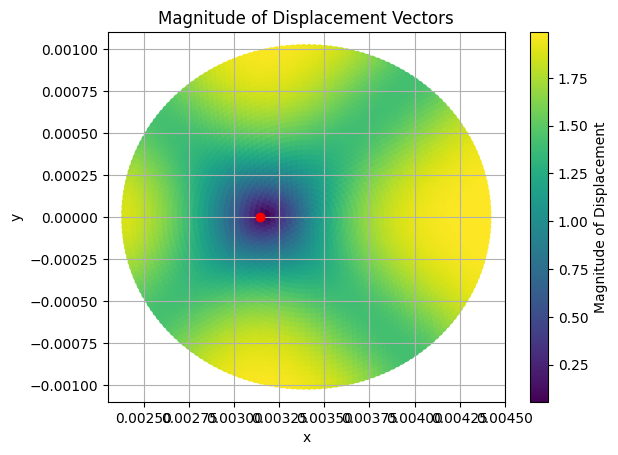

0.039976037132691454


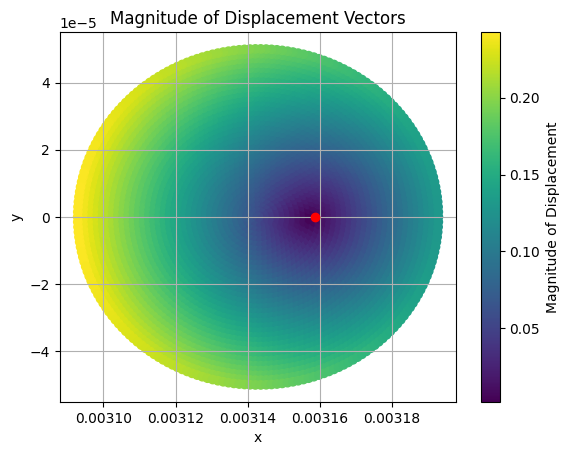

0.0015640729093296044


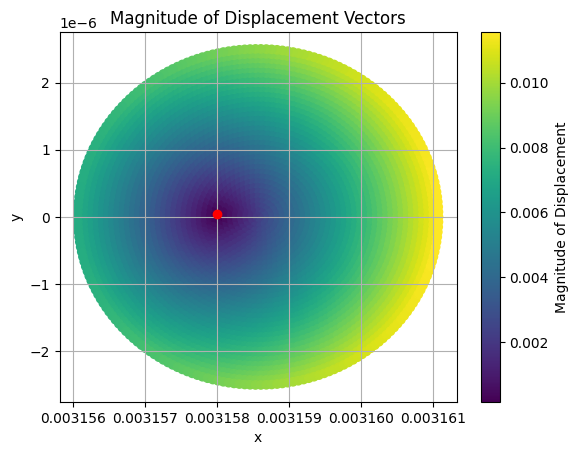

0.00015540274317817488


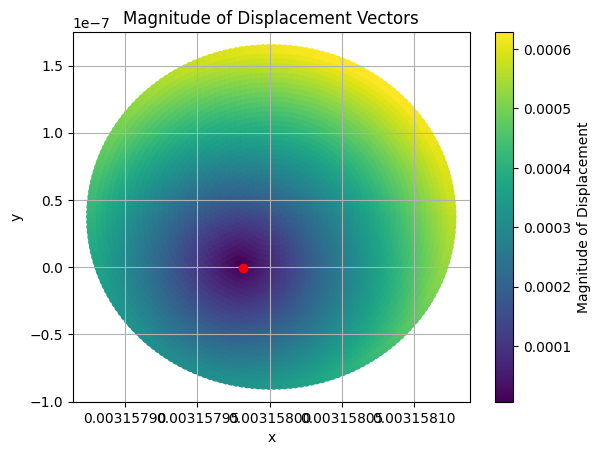

2.582003095012181e-06


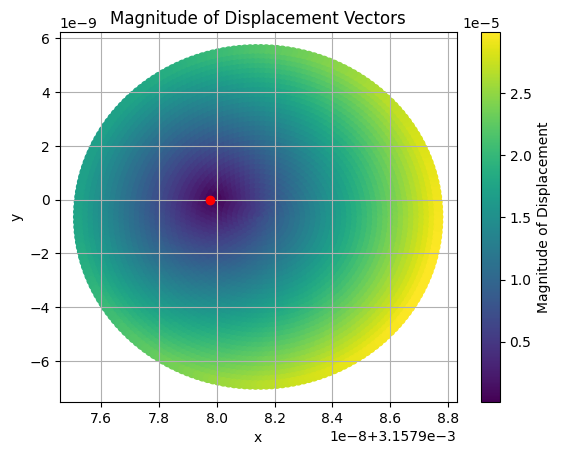

1.3354993737118922e-07


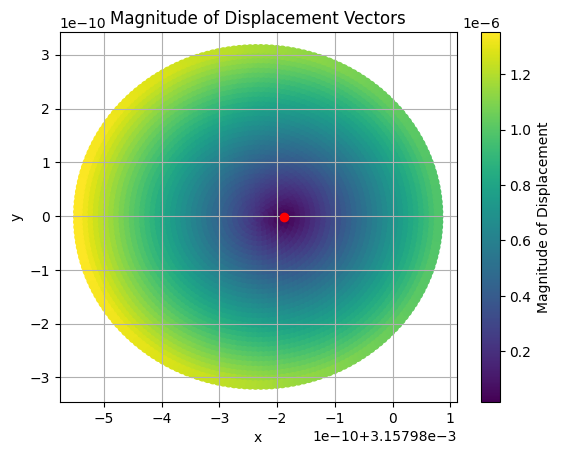

1.552514427857445e-08


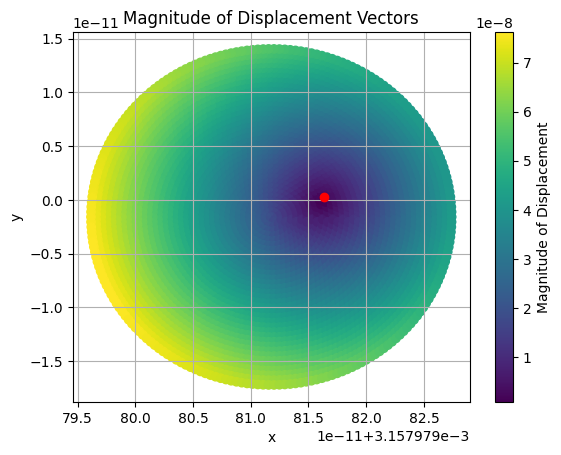

1.3528554694409135e-09


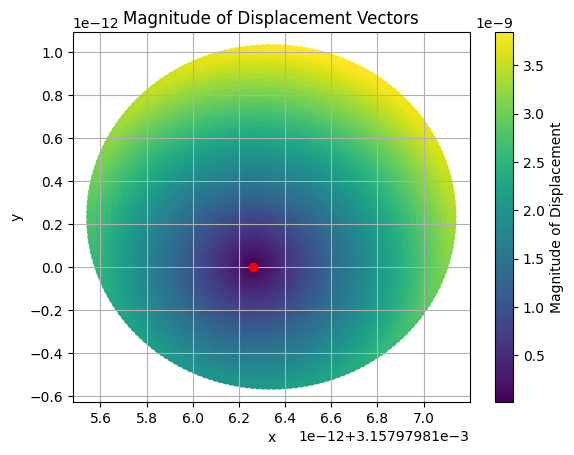

5.271037148475306e-10


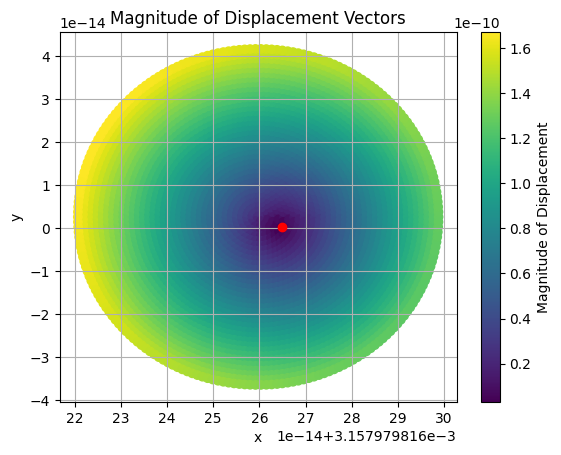

5.34580412647964e-10


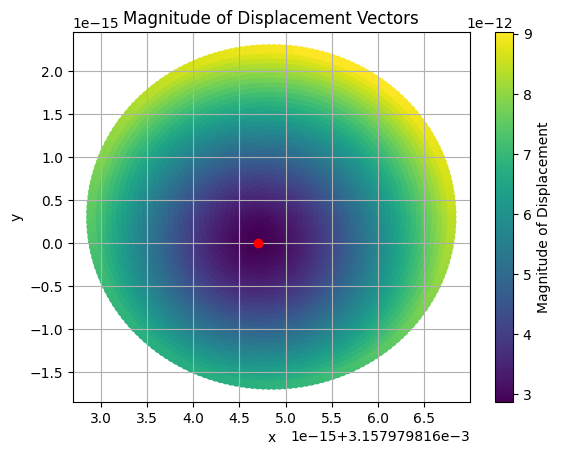

5.334033168644222e-10


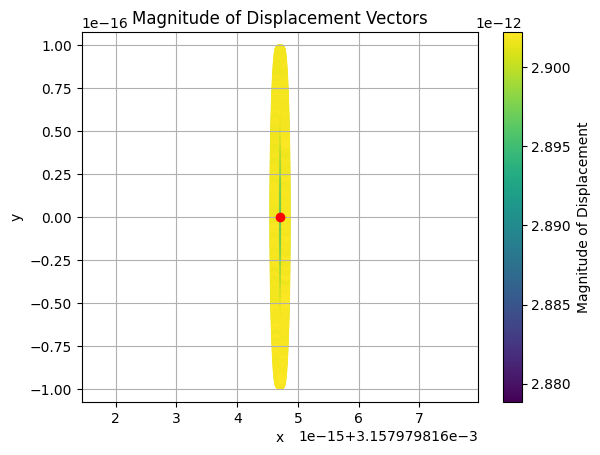

5.334033168644222e-10


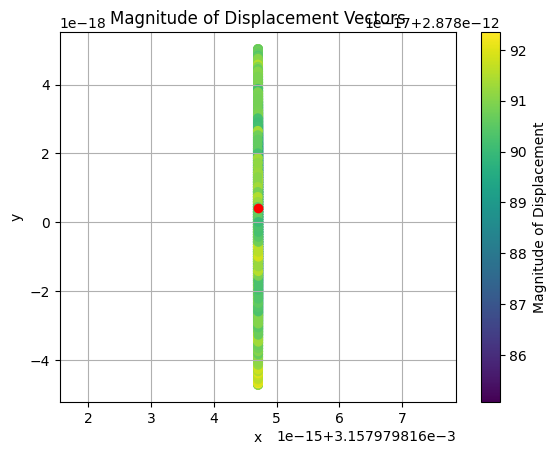

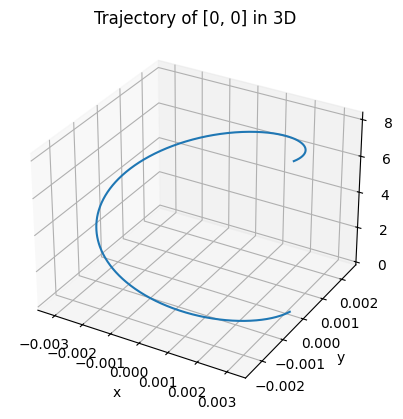

Condition satisfied: True


In [ ]:
eps = 5*1e-3
delta = 0
gamma = 1
#omega = 0.76374
omega = 1*0.76374
phi = np.pi

grid_radius = eps/5
n_rings = 35
n_iterations = 12

stable_point = simulate_trajectories(n_rings, grid_radius, center=np.array([[0.0034,0]]).T, eps=eps, gamma=gamma, delta=delta, omega=omega, phi=phi)
for i in range(1,n_iterations):
    grid_radius = grid_radius * 5*1e-2
    print(np.linalg.norm(poincare_map(stable_point,eps,gamma,delta,omega,phi,1)-stable_point))
    stable_point = simulate_trajectories(n_rings, grid_radius, center=stable_point.reshape(2,1), eps=eps, gamma=gamma, delta=delta, omega=omega, phi=phi)


plot_trajectory(stable_point, eps, gamma, delta, omega, phi, 1)

result = check_condition(delta, gamma, omega)
print(f"Condition satisfied: {result}")

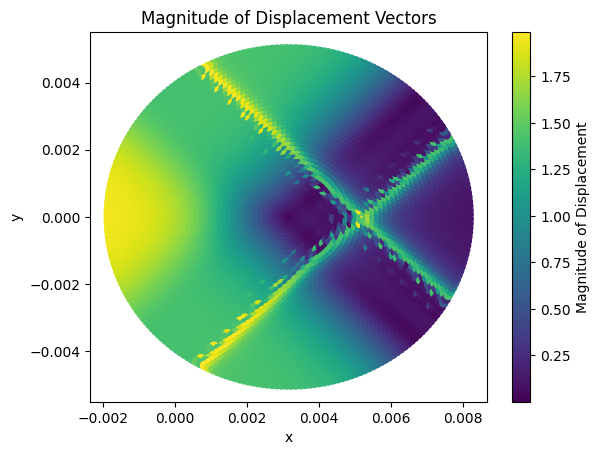

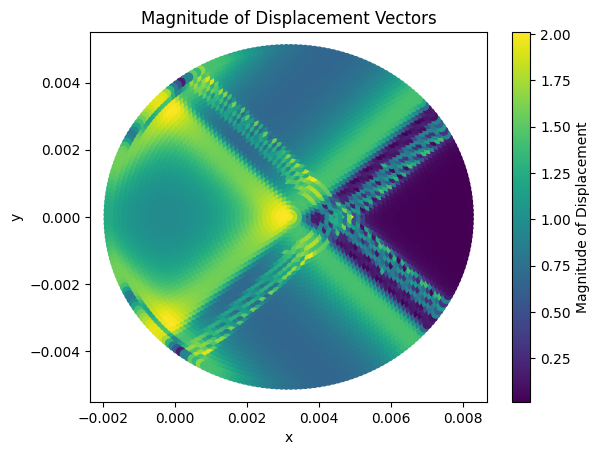

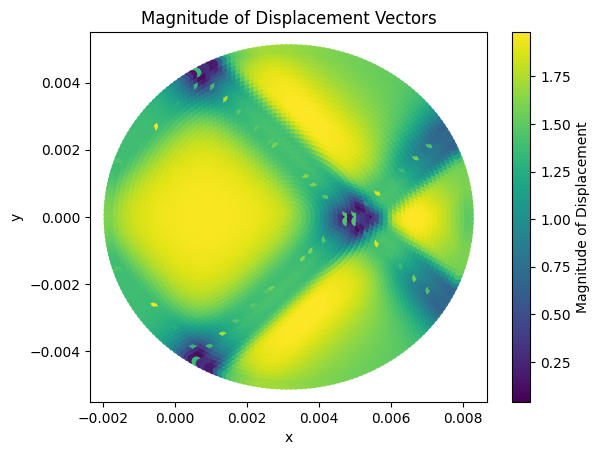

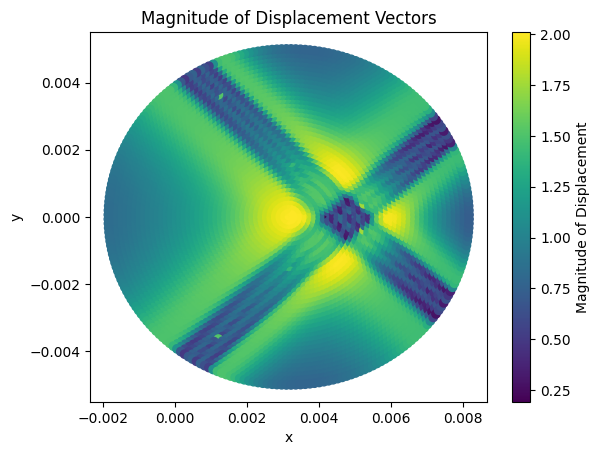

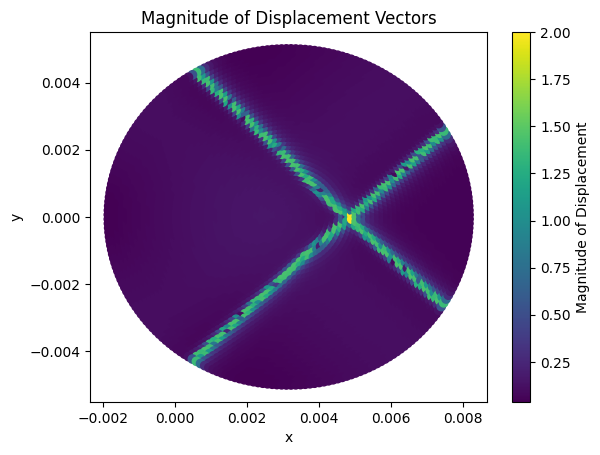

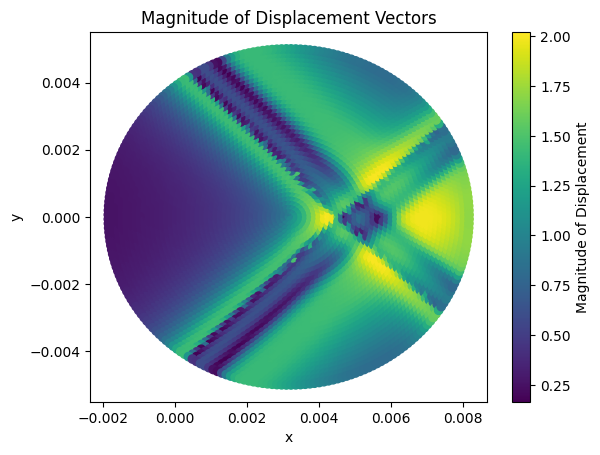

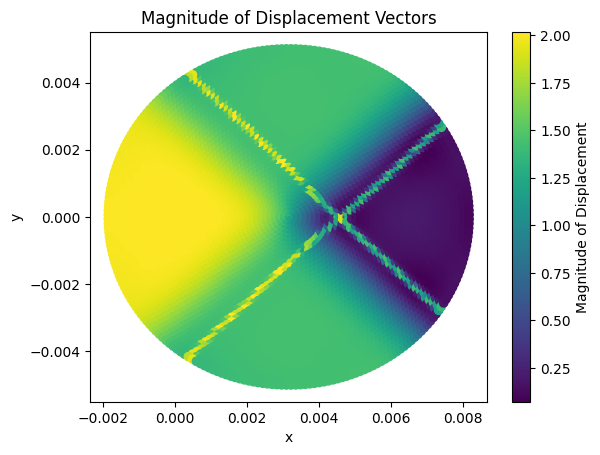

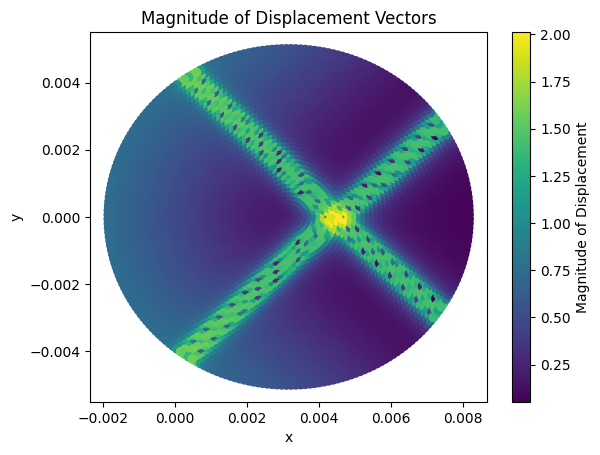

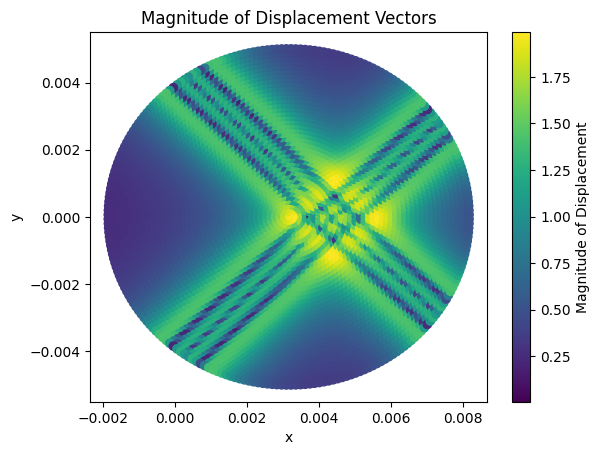

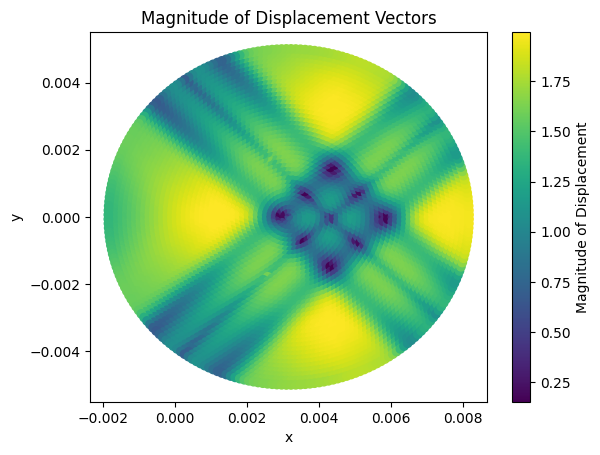

In [ ]:
eps = 5*1e-3
delta = 0
gamma = 1
omega = 0.76374
initial_size=0.5
final_size = 0.1
n_points = 10
omegas = np.linspace(final_size,initial_size,n_points)*omega
phi = np.pi

grid_radius = eps
n_rings = 40

for i in range(n_points):
  simulate_trajectories(n_rings, grid_radius, stable_point[:,np.newaxis], eps=eps, gamma=gamma, delta=delta, omega=omegas[i], phi=phi)


In [ ]:
dist = 1e-10
n_points = 50000
n_iterations_stable=2
n_iterations_unstable=2

Wu, Ws = vectorized_compute_manifolds(stable_point, dist, n_points, n_iterations_stable, n_iterations_unstable, eps, gamma, delta, omega, phi)

temp = Wu[:,-n_points:]
Wu = filter_close_points(Wu[:,:-n_points], 1e-2)
Wu = np.append(Wu,temp,axis=1)
temp = Ws[:,-n_points:]
Ws = filter_close_points(Ws[:,:-n_points], 1e-2)
Ws = np.append(Ws,temp,axis=1)
gc.collect()

4119

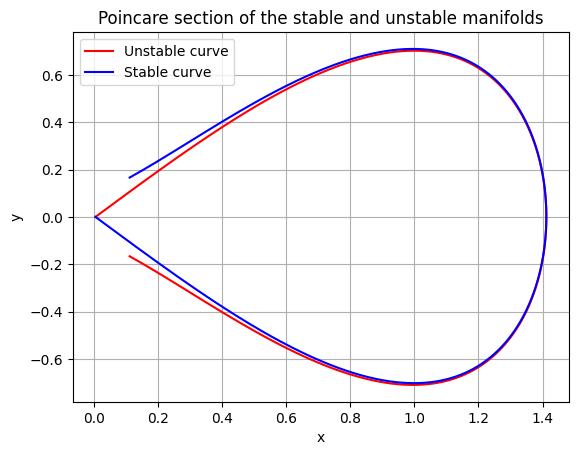

In [ ]:
plt.plot(Wu[0],Wu[1],"r", label="Unstable curve")
plt.plot(Ws[0],Ws[1],"b", label="Stable curve")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Poincare section of the stable and unstable manifolds")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Wu_iterated = Wu
Ws_iterated = Ws

In [ ]:
n_reiterations = 100
Wu_iterated, Ws_iterated = append_iterations(Wu_iterated,Ws_iterated,n_points,n_reiterations,eps,gamma,delta,omega,phi)

In [ ]:
n_delete_iterations = 5000
Wu_iterated = Wu_iterated[:,:-n_delete_iterations]
Ws_iterated = Ws_iterated[:,:-n_delete_iterations]

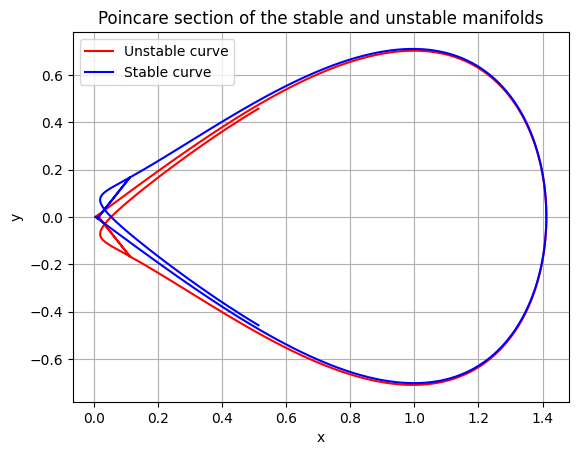

In [ ]:
plt.plot(Wu_iterated[0],Wu_iterated[1],"r", label="Unstable curve")
plt.plot(Ws_iterated[0],Ws_iterated[1],"b", label="Stable curve")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Poincare section of the stable and unstable manifolds")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Wu = filter_close_points(Wu_iterated, 1e-2)
Ws = filter_close_points(Ws_iterated, 1e-2)

In [ ]:
Wu_saved.append(Wu)
Ws_saved.append(Ws)

In [ ]:
len(Wu_saved)

21

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML  # For displaying in Colab
import pickle

In [ ]:
with open('Wu_saved.pkl', 'wb') as f:  # 'wb' opens the file in binary write mode
    pickle.dump(Wu_saved, f)

In [ ]:
with open('Ws_saved.pkl', 'wb') as f:  # 'wb' opens the file in binary write mode
    pickle.dump(Ws_saved, f)

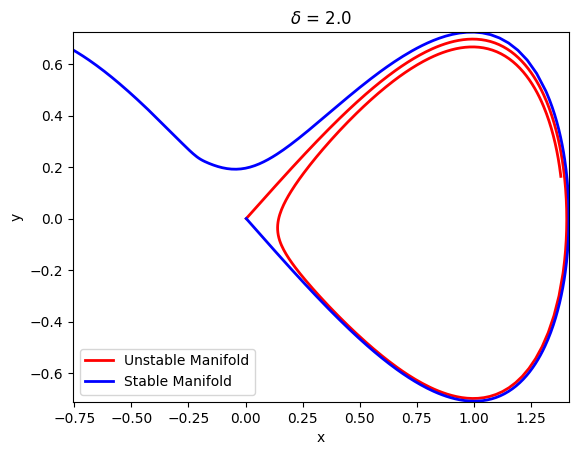

In [ ]:
# Assuming Wu_saved and Ws_saved are your lists of NumPy arrays

fig, ax = plt.subplots()

# Initialize empty lines for plotting
line_wu, = ax.plot([], [], 'r-', lw=2, label='Unstable Manifold')
line_ws, = ax.plot([], [], 'b-', lw=2, label='Stable Manifold')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='lower left')  # Add legend

# Function to initialize the plot
def init():
    line_wu.set_data([], [])
    line_ws.set_data([], [])

    # Calculate limits to keep scaling consistent
    Wu_glued = np.concatenate(Wu_saved, axis=1)
    Ws_glued = np.concatenate(Ws_saved, axis=1)
    all_x = np.concatenate([Wu_glued[0], Ws_glued[0]])
    all_y = np.concatenate([Wu_glued[1], Ws_glued[1]])

    ax.set_xlim(min(all_x), max(all_x))
    ax.set_ylim(min(all_y), max(all_y))
    return line_wu, line_ws

# Function to update the plot for each frame
def animate(i):
    wu_data = Wu_saved[i]  # Get data for Wu
    ws_data = Ws_saved[i]  # Get data for Ws

    line_wu.set_data(wu_data[0], wu_data[1])  # Update Wu line
    line_ws.set_data(ws_data[0], ws_data[1])  # Update Ws line

    ax.set_title(f"$\delta$ = {i/10:.1f}")  # Set title (optional)
    return line_wu, line_ws
# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(Wu_saved),
                              init_func=init, blit=True, interval=500)

# Display in Colab
HTML(ani.to_html5_video())

In [ ]:
ani.save('my_animation.gif', writer='pillow')